Hugging Face provides access to models (both the code that implements them and their pre-trained weights), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate `datasets` package. It has implementations in PyTorch, Tensorflow, and Flax!


We're going to go through:
* Introduction to using Hugging Face Transformers
* Finetuning a Pre-Trained Model for Sentiment Analysis
* Example Finetuning on Generation Tasks
* Leveraging HuggingFace Pipelines for Sentiment Analysis

## Importing Libraries and Configuration

In [1]:
# !pip install transformers
# !pip install datasets

In [2]:
from collections import defaultdict, Counter
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback, EarlyStoppingCallback
from transformers import pipeline
from transformers import AutoModelForCausalLM
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader

import json
import os
import pandas as pd
import numpy as np
import torch
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Helper functions

In [3]:
#Print encoding
def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

In [4]:
#Take the first 50 tokens for speed/running on CPU
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

In [5]:
#Get accuracy
def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}

In [6]:
#Defining class for logging callbacks
class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

## Introduction to Using Hugging Face Transformers

You can find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

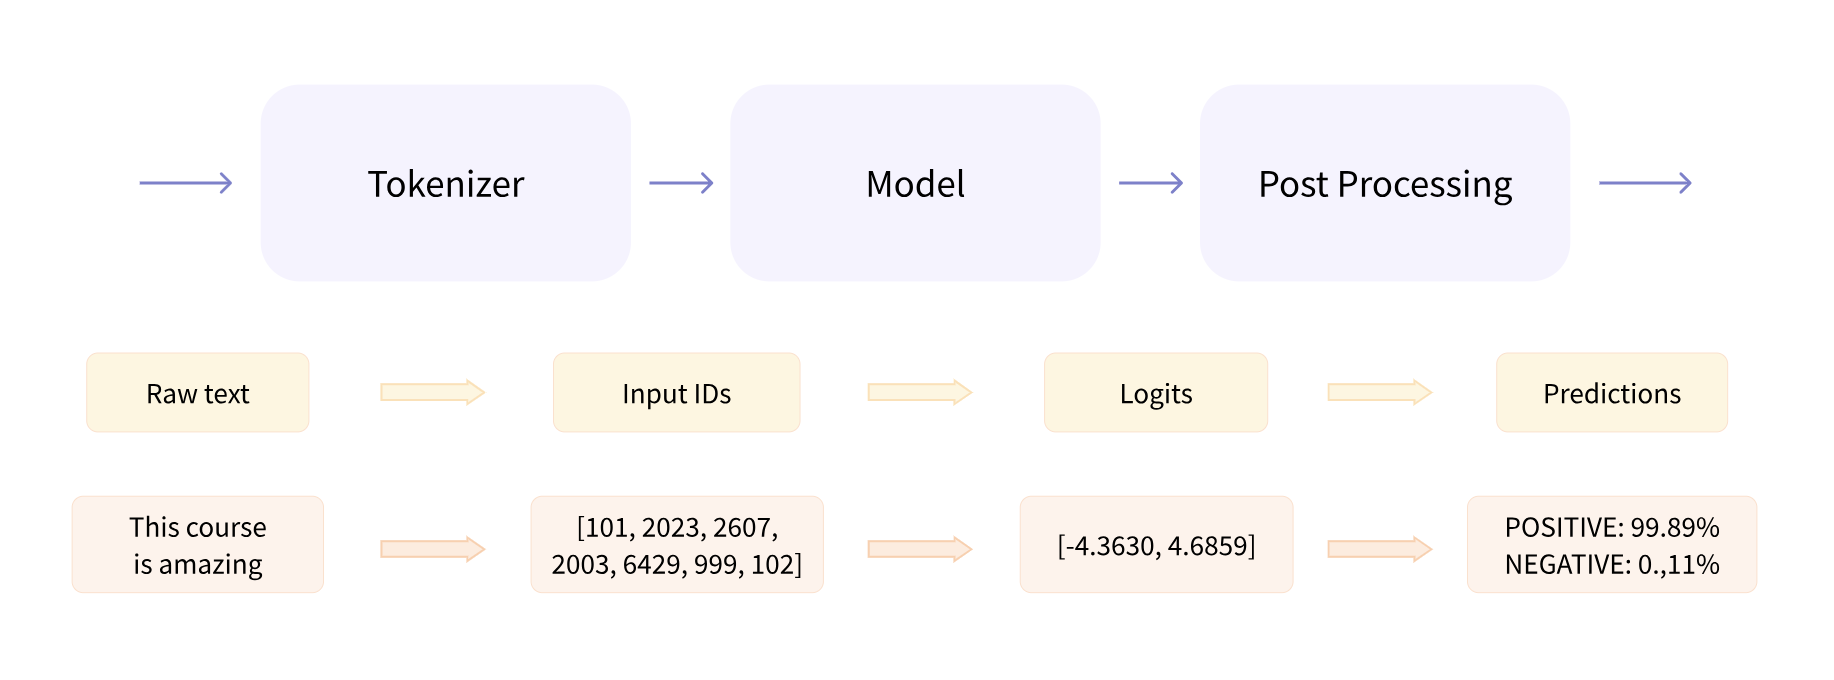

### Tokenization

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.

You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [7]:
#Using Tokenizer class specific to model (good for specifying slow versions)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)

#Using AutoTokenizer (defaults to fast version)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
print(tokenizer)

PreTrainedTokenizer(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
PreTrainedTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
PreTrainedTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [8]:
#Custom input
inputs = "I'm excited to learn about Hugging Face Transformers!"

#Calling the tokenizer
tokenized_inputs = tokenizer(inputs, return_tensors="pt")

In [9]:
print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

Vanilla Tokenization
{
    input_ids:
        tensor([[  101,   146,   112,   182,  7215,  1106,  3858,  1164, 20164, 10932,
         10289, 25267,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}



### Models

Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).

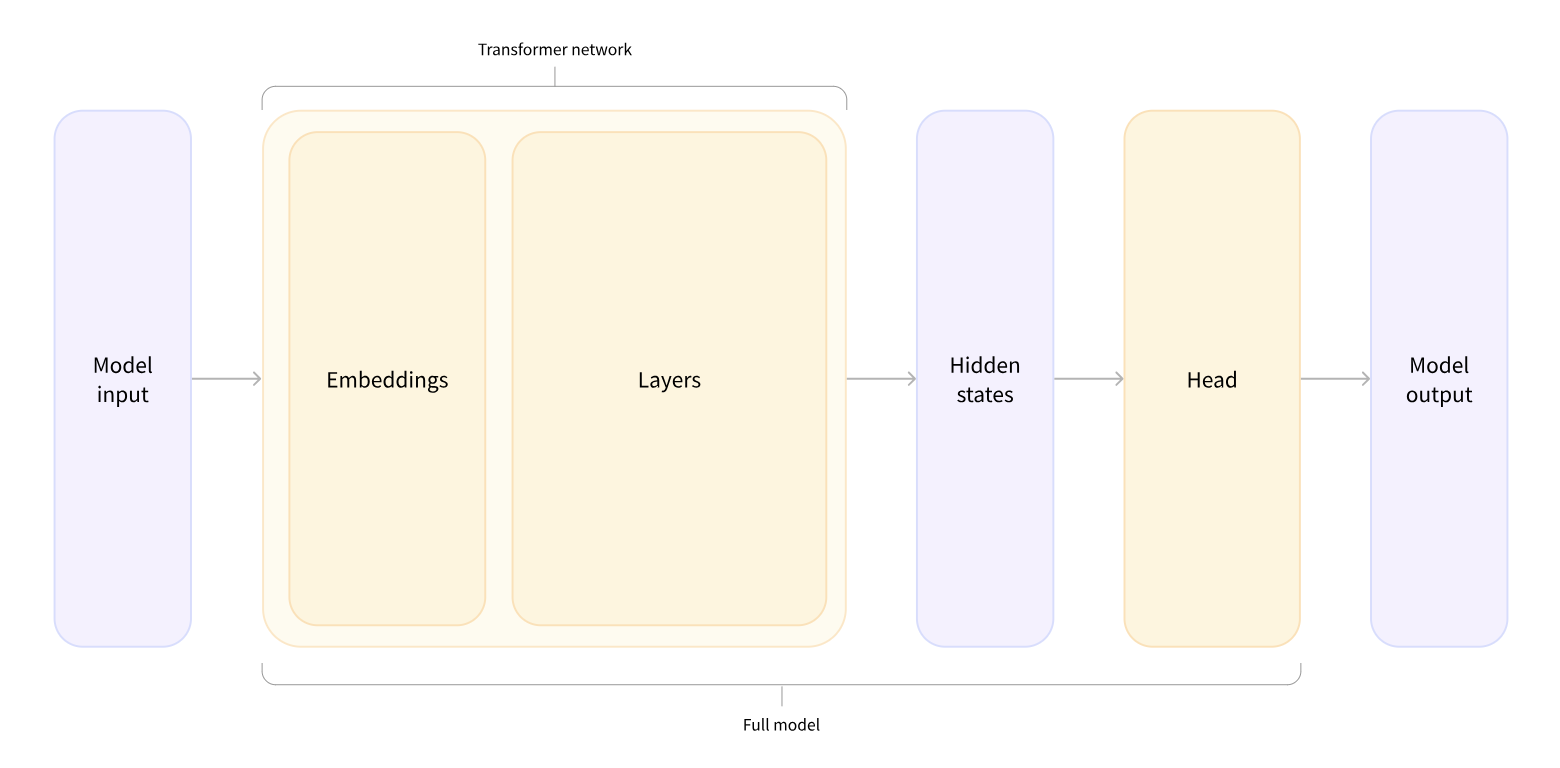

Here are some examples.
```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.


In [10]:
#Initializing models
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is super easy. They take inputs as keyword arguments

In [11]:
#Getting outputs from the model
outputs = model(**tokenized_inputs)
prediction = torch.argmax(outputs.logits)

In [12]:
#Print outputs
print("Input:")
print(inputs)
print()

print("Model Outputs:")
print(outputs)
print()

labels = ['NEGATIVE', 'POSITIVE']
print(f"The prediction is {labels[prediction]}")

print()
print(f"Distribution over labels: {torch.softmax(outputs.logits, dim=1)}")

Input:
I'm excited to learn about Hugging Face Transformers!

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-0.2574,  0.0633]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE

Distribution over labels: tensor([[0.4205, 0.5795]], grad_fn=<SoftmaxBackward0>)


If you notice, it's a bit weird that we have two classes for a binary classification task - you could easily have a single class and just choose a threshold. It's like this because of how huggingface models calculate the loss. This will increase the number of parameters we have, but shouldn't otherwise affect performance.

In [13]:
# To calculate the loss, we need to pass in a label:
tokenized_inputs['labels'] = torch.tensor([1])

#Getting outputs from the model
outputs = model(**tokenized_inputs)
prediction = torch.argmax(outputs.logits)

#Printing prediction
print(f"The prediction is {labels[prediction]}")

The prediction is POSITIVE


## Finetuning a Pre-Trained Model for Sentiment Analysis

For your projects, you are much more likely to want to finetune a pretrained model. This is a little bit more involved, but is still quite easy.

### Initializing Data

In [14]:
#Load dataset
imdb_dataset = load_dataset("imdb")

# Take 128 random examples for train and 32 validation
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

#Printing dataset
small_imdb_dataset

Found cached dataset imdb (/Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-7b6643e860da141c.arrow
Loading cached shuffled indices for dataset at /Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d3d289c2e4f2e104.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 32
    })
})

In [15]:
small_imdb_dataset['train'][:10]

{'text': ["Probably Jackie Chan's best film in the 1980s, and the one that put him on the map. The scale of this self-directed police drama is evident from the opening and closing scenes, during which a squatters' village and shopping mall are demolished. There are, clearly, differences between the original Chinese",
  'A wonderful movie! Anyone growing up in an Italian family will definitely see themselves in these characters. A good family movie with sadness, humor, and very good acting from all. You will enjoy this movie!! We need more like it.',
  'HORRENDOUS! Avoid like the plague. I would rate this in the top 10 worst movies ever. Special effects, acting, mood, sound, etc. appear to be done by day care students...wait, I have seen programs better than this. Opens like a soft porn show with a blurred nude female doing a',
  'And I absolutely adore Isabelle Blais!!! She was so cute in this movie, and far different from her role in "Quebec-Montreal" where she was more like a man-eat

In [16]:
#Prepare the dataset - this tokenizes the dataset in batches of 16 examples
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True),
    batched=True,
    batch_size=16
)

Loading cached processed dataset at /Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-6068d29bf0235666.arrow
Loading cached processed dataset at /Users/anantagarwal/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-e486f533f0b5c5f7.arrow


### Training with PyTorch

In [17]:
os.makedirs("sess1-checkpoints/",exist_ok=True)

In [18]:
small_tokenized_dataset_pt = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset_pt = small_tokenized_dataset_pt.rename_column("label", "labels")
small_tokenized_dataset_pt.set_format("torch")
small_tokenized_dataset_pt['train'][0:2]

{'labels': tensor([1, 1]),
 'input_ids': tensor([[  101, 10109,  9662, 10185,   112,   188,  1436,  1273,  1107,  1103,
           3011,   117,  1105,  1103,  1141,  1115,  1508,  1140,  1113,  1103,
           4520,   119,  1109,  3418,  1104,  1142,  2191,   118,  2002,  2021,
           3362,  1110, 10238,  1121,  1103,  2280,  1105,  5134,  4429,   117,
           1219,  1134,   170,  4816,  6718, 18899,   112,  1491,  1105,  6001,
           8796,  1132,  6515,   119,  1247,  1132,   117,  3817,   117,  5408,
           1206,  1103,  1560,  1922,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,   138,  7310,  2523,   106, 15859,  2898,  1146,  1107,  1126,
           2169,  1266,  1209,  5397,  1267,  2310,  1107,  1292,  2650,   119,
            138,  1363,  1266,  2523,  1114, 12928,   1

In [19]:
#Initialize train and test dataloaders
train_dataloader = DataLoader(small_tokenized_dataset_pt['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset_pt['val'], batch_size=16)

In [20]:
#Initialize model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

In [21]:
#Initialize hyperparameters
num_epochs = 3
lr_rate = 2e-5
weight_decay = 0.01
num_training_steps = 3 * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=lr_rate, weight_decay=weight_decay)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [22]:
#Train model
best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):
        
        #Get output from forward propagation
        output = model(**batch)
        
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
    #Validation
    model.eval()
    loss = 0
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss
    
    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"sess1-checkpoints/epoch_{epoch}.pt"
        )  

  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss: 0.6895318627357483
Saving checkpoint!
Validation loss: 0.6831762790679932
Saving checkpoint!
Validation loss: 0.6812078356742859
Saving checkpoint!


### Training with HuggingFace's Trainer 

In [23]:
#Initialize model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b

In [24]:
#Initializing training parameters
num_epochs = 3
lr_rate = 2e-5
seed = 224

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). Some things you can control include:
* learning rate, weight decay, gradient clipping, 
* checkpointing, logging, and evaluation frequency
* where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

In [25]:
#Specify training parameters
arguments = TrainingArguments(
    output_dir="sess1-checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_epochs,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=lr_rate,
    load_best_model_at_end=True,
    seed=seed
)

The `Trainer` actually performs the training. You can pass it the `TrainingArguments`, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The `compute_metrics` function is called at the end of evaluation/validation to calculate evaluation metrics.

In [26]:
#Initialize trainer
trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#### Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [27]:
#Adding callbacks
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sess1-checkpoints/log.jsonl"))

In [28]:
#Training the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 128
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 24
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.679584,0.687500
2,No log,0.674388,0.656250
3,No log,0.671466,0.656250


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 16
Saving model checkpoint to sess1-checkpoints/checkpoint-8
Configuration saved in sess1-checkpoints/checkpoint-8/config.json
Model weights saved in sess1-checkpoints/checkpoint-8/pytorch_model.bin
tokenizer config file saved in sess1-checkpoints/checkpoint-8/tokenizer_config.json
Special tokens file saved in sess1-checkpoints/checkpoint-8/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation **

TrainOutput(global_step=24, training_loss=0.6797194480895996, metrics={'train_runtime': 47.0513, 'train_samples_per_second': 8.161, 'train_steps_per_second': 0.51, 'train_loss': 0.6797194480895996, 'epoch': 3.0})

In [29]:
#Evaluating the model
## Gives only evaluation metrics
# results = trainer.evaluate()

#Gives evaluation metrics and predictions
results = trainer.predict(small_tokenized_dataset['val'])

results

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 32
  Batch size = 16


PredictionOutput(predictions=array([[ 0.05166959, -0.02979963],
       [-0.00876569, -0.00033116],
       [ 0.01894751, -0.00761867],
       [ 0.04204001, -0.04266857],
       [-0.05265911,  0.03134458],
       [-0.01094646, -0.00424641],
       [ 0.08764569, -0.05849315],
       [ 0.00652962, -0.02086476],
       [-0.01099914,  0.00831795],
       [-0.02365928,  0.00084529],
       [-0.01209686,  0.01717304],
       [ 0.138088  , -0.06216865],
       [ 0.06676395, -0.04799144],
       [-0.04209819,  0.05349649],
       [ 0.09472835, -0.00604632],
       [ 0.14455682, -0.1006428 ],
       [ 0.09913993, -0.05494659],
       [-0.05279994,  0.01995683],
       [ 0.05482469, -0.01897132],
       [-0.11317836,  0.03054755],
       [ 0.15454106, -0.09116852],
       [ 0.04013463,  0.00193209],
       [-0.01553752,  0.01822935],
       [ 0.03915691, -0.01670553],
       [-0.00870507,  0.04979502],
       [-0.02795853,  0.03250973],
       [ 0.00264846, -0.01464019],
       [-0.02723577,  0.00

In [30]:
#Loading saved model, and getting predictions
test_str = "I enjoyed the movie!"
tokenized_inputs = tokenizer(test_str, return_tensors="pt")

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sess1-checkpoints/checkpoint-24")
prediction = torch.argmax(finetuned_model(**tokenized_inputs).logits)
print(labels[prediction])

loading configuration file sess1-checkpoints/checkpoint-24/config.json
Model config DistilBertConfig {
  "_name_or_path": "sess1-checkpoints/checkpoint-24",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.22.0.dev0",
  "vocab_size": 28996
}

loading weights file sess1-checkpoints/checkpoint-24/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the 

POSITIVE


Included here are also some practical tips for fine-tuning:

**Good default hyperparameters.** The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* Epochs: {2, 3, 4} (larger amounts of data need fewer epochs)
* Batch size (bigger is better: as large as you can make it)
* Optimizer: AdamW
* AdamW learning rate: {2e-5, 5e-5}
* Learning rate scheduler: linear warm up for first {0, 100, 500} steps of training
* weight_decay (l2 regularization): {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful including logging, saving model checkpoints, and more! You can even sub-class it to add your own personalized components. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about the Trainer.

## Example Finetuning on Generation Tasks

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models. For example.

In [31]:
#Initialize tokenizer
gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/anantagarwal/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params":

In [32]:
#Initialize model
gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')

loading configuration file config.json from cache at /Users/anantagarwal/.cache/huggingface/hub/models--distilgpt2/snapshots/38cc92ec43315abd5136313225e95acc5986876c/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_s

In [33]:
#Prevents warning during decoding
gpt2.config.pad_token_id = gpt2.config.eos_token_id 

In [34]:
#Tokenize input prompt
prompt = "Once upon a time"
tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

In [35]:
#Generate output
for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

1) Once upon a time of war, many people fought against the Russian invaders and their armies. These forces have long been part of our national security.


They’d fought in the Second World War with great courage. But they would never
2) Once upon a time a creature that does not seem to have the strength to attack that creature is immediately taken for granted. A creature must spend one more hour per minute on its ability. A creature with a Wisdom score of 1 or less can use any
3) Once upon a time of the dawn of the world the last thing was left to a human soul who couldn't see it was time to take a long look at it. Even if he did, the very essence of what made the person the greatest man
4) Once upon a time of crisis of the American Republic, President Franklin D. Roosevelt, a man whose political system was a failure and whose people were being manipulated, was now trying to change it. This was an experiment in the most profound possible way of
5) Once upon a time when the sun was shin

## Leveraging Hugging Face Pipelines for Sentiment Analysis

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline) interface. 

For your projects, you likely won't be using it too much, but it's still worth knowing about!

Here's an example with Sentiment Analysis:

In [36]:
#Initializing pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

loading configuration file config.json from cache at /Users/anantagarwal/.cache/huggingface/hub/models--siebert--sentiment-roberta-large-english/snapshots/e78aa2b262b5f58e659fd765676b19c16a34f745/config.json
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.

You can run the pipeline by just calling it on a string

In [37]:
sentiment_analysis("Hugging Face Transformers is really cool!")

[{'label': 'POSITIVE', 'score': 0.998448371887207}]

Or on a list of strings:

In [38]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'POSITIVE', 'score': 0.9988769888877869},
 {'label': 'NEGATIVE', 'score': 0.9994940757751465}]

You can find more information on pipelines (including which ones are available) [here](https://huggingface.co/docs/transformers/main_classes/pipelines)